## 개요
이 프로젝트에선, 현재 출시되어 관객에게 상영한 영화의 줄거리, 감독, 관람객 평 등의 데이터를 분석하여 추후 새로운 영화가 개봉할 때 해당 영화의 평점을 학습한 데이터를 바탕으로 예측해 내는 것을 주 목표로 합니다. 이를 위해서 필요한 기능은:

- [네이버 영화](https://movie.naver.com)에서 영화 데이터를 긁어와 데이터 시트에 정리
- 이렇게 정리한 데이터를 토큰화: 머신러닝 알고리즘이 알아듣기 쉽게, 정확하게 값을 낼 수 있는 형식으로 변환
- 머신러닝 알고리즘을 구축하여 영화 평점을 예측해내는 모델 개발

정도가 됩니다. 

이러한 프로젝트를 구상하게 된 계기는, Elice의 인공지능/머신러닝 기초 강의의 Naive-Beyes 알고리즘을 사용하여 영화평 감정분석 알고리즘을 만드는 방법을 배운 이후로, 감정의 긍정/부정 여부 뿐만이 아닌 영화의 재미와 같은 것도 머신러닝 알고리즘이 예측해낼 수 있지 않을까? 라는 일종의 실험으로 구상한 것이 이 프로젝트의 시작이었습니다. 

 **주의:**

현재 데이터 마이닝 부분은 구현되어 있으나, 머신러닝 알고리즘 부분이 완벽하지 않은 관계로, 아직 원활히 구동되지 않을 수 있습니다. 양해 부탁드립니다.

## 데이터 크롤러
크롤러에는 크게 세 가지 모듈을 사용합니다. 괄호 안에 표시된 모듈 이름을 모두 Python의 `pip` 모듈을 사용하여 설치를 진행하셔야 합니다. 

- `requests`: Python을 통하여 웹 사이트를 불러오는 데 사용합니다. 일종의 코딩에 쓰이는 브라우저라고 생각하시면 됩니다.
- `bs4 (BeautifulSoup)`: 위의 Requests를 통해 불러온 웹 페이지를 Python과 유저가 알아듣기 쉽게 트리 형식으로 변환해 주는 강력한 툴입니다. 
- `pandas`: Python에서 사용할 수 있는 강력한 데이터프레임 모듈입니다. 빅 데이터를 처리하는 데 매우 유용합니다. 

이 두 모듈을 사용하여 네이버 영화에서 영화의 정보를 긁어오는 크롤러를 만들어 봅시다. 

In [1]:
#!pip install konlp

In [2]:
from collections import defaultdict
from glob import glob
from bs4 import BeautifulSoup
from lxml import html
import os
import re
import time
import numpy as np
import pandas as pd
import requests
#import utils
import requests
import pandas as pd
import urllib.parse
import time
import torch
import datetime
import random

import tensorflow as tf
from konlpy.tag import Twitter
import numpy as np
import gensim


In [3]:
BASEURL     = 'http://movie.naver.com/movie/point/af/list.nhn'
RATINGURL   = BASEURL + '?&page=%s'
MOVIEURL    = BASEURL + '?st=mcode&target=after&sword=%s&page=%s'
DATADIR     = 'data/ratings'
INDEXFILE   = 'index.txt'
TMPFILE     = 'data/ratings_all.txt'
RATINGSFILE = 'data/ratings.txt'

SEED        = 1234
SLEEP       = 600
NDOCS       = 200000

extract_nums = lambda s: re.search('\d+', s).group(0)
sanitize_str = lambda s: s.strip()

In [4]:
source = BeautifulSoup(requests.get(BASEURL).content, 'html.parser')
alltables = source.find_all("table")
table = source.find("table", {"id":"thetable"})

In [5]:
# %%time
# moviecomments = pd.DataFrame(columns=['ID', 'TITLE', 'POINT', "COMMENT"])
# data = []

# for page in range(1, 10001):

#     RATINGURL = BASEURL + '?&page='+str(page)
#     if page % 200 == 0:
#         dfcomment = pd.DataFrame(data, columns=['ID', 'TITLE', 'POINT', "COMMENT"])
#         moviecomments = pd.concat([moviecomments, dfcomment])
#         print(RATINGURL, len(data), len(moviecomments))
#         data = []
    
#     source = BeautifulSoup(requests.get(RATINGURL).content, 'html.parser')
    
#     for tr in source.find_all('tr')[1:]:
#         try:
#             tds = tr.find_all('td')
#             iid = tds[0].text
#             title = tds[1].find("a").text
#             point = tds[1].find("div").text.replace("\n별점 - 총 10점 중", "").replace("\n", "")
#             contents = tds[1].text.strip().split('\n')[4]
#             data.append([iid, title, point, contents])
#             continue
#         except:
#             print("Error Pass!!")
#     time.sleep(0.1)
    
# moviecomments.to_csv('naver.csv', sep=',')    

In [6]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
    return data


In [7]:
dfcomment = pd.read_csv('naver.csv', sep=',')

In [8]:
moviecomments = dfcomment.copy()

In [9]:
moviecomments = moviecomments[moviecomments['POINT'].isin(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])]

In [10]:
moviecomments['POINT'] = moviecomments['POINT'].astype(int)
moviecomments['Y'] = -1
moviecomments.loc[moviecomments['POINT']>=9, "Y"] = 1
moviecomments.loc[moviecomments['POINT']<=4, "Y"] = 0

### 중립은 제거, 긍정과 부정 리뷰만 데이터로 사용

In [11]:
moviecomments = moviecomments[moviecomments['Y']>=0]

In [12]:
moviecomments.head()

,Unnamed: 0,ID,TITLE,POINT,COMMENT,Y
0,0,16905147,어쌔신 걸스,1,감독새끼 집주소가 시급하다. 문재인이 지 페북에 쳐올린 근친야동이 더 잼날듯.,0
1,1,16905146,사랑하기 때문에,10,NaN,1
2,2,16905145,셰이프 오브 워터: 사랑의 모양,10,솔직히 좀 불쾌할걸 예상했는데 그럴생각 1도없이 완전히 매료되어버렸다... 그나저나...,1
3,3,16905144,들어는 봤니? 모건 부부,10,오랜만에 넘 재밌게 본 로맨틱코미디 영화네요!뉴욕과 시골을 넘나드는 좀 어이없으면서...,1
4,4,16905143,침입자,1,기대 안하고 봤는데 기대 이하였음..,0


### 리뷰 문장 추출

In [13]:
sentences = moviecomments['COMMENT']
sentences[:10]

0         감독새끼 집주소가 시급하다. 문재인이 지 페북에 쳐올린 근친야동이 더 잼날듯. 
1                                                  NaN
2    솔직히 좀 불쾌할걸 예상했는데 그럴생각 1도없이 완전히 매료되어버렸다... 그나저나...
3    오랜만에 넘 재밌게 본 로맨틱코미디 영화네요!뉴욕과 시골을 넘나드는 좀 어이없으면서...
4                                기대 안하고 봤는데 기대 이하였음.. 
5                              그때의 감동 팬들을 생각하는 마음과 교감 
6                                                  NaN
7             다른 세대의 편안한 공감대 뻔한데 그저 흐뭇하다 힐링되는 동화같은 영화 
8                                               ..... 
9                                                  NaN
Name: COMMENT, dtype: object

In [14]:
# 데이터 전처리
def preprocessor(text):
    #특수기호, hTML 태그 등 제거 (단 이모티콘은 남겨둠)
    text = re.sub('[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)|\^.?\^', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    return text

In [15]:
sentences[:5]

0         감독새끼 집주소가 시급하다. 문재인이 지 페북에 쳐올린 근친야동이 더 잼날듯. 
1                                                  NaN
2    솔직히 좀 불쾌할걸 예상했는데 그럴생각 1도없이 완전히 매료되어버렸다... 그나저나...
3    오랜만에 넘 재밌게 본 로맨틱코미디 영화네요!뉴욕과 시골을 넘나드는 좀 어이없으면서...
4                                기대 안하고 봤는데 기대 이하였음.. 
Name: COMMENT, dtype: object

In [16]:
moviecomments = moviecomments[~moviecomments['COMMENT'].isnull()]

In [17]:
from time import time
import re

# stime = time()
# sentences = sentences.apply(preprocessor)

# print('전처리 처리시간 [%d]'%(time()-stime))


In [18]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

porter = PorterStemmer()
#stop = stopwords.words('Korean')

def tokenizer(text):
    return text.split()

def  tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]


  


In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(moviecomments['COMMENT'], moviecomments['Y'],train_size=0.7, random_state=1, shuffle=False)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
#from mylib.tokenizer import tokenizer, tokenizer_porter
import pickle
import os


In [21]:
tfidf = TfidfVectorizer(lowercase=False, tokenizer=tokenizer)

In [22]:
lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(C=10.0, penalty='l2', random_state=0))])

In [23]:
lr_tfidf.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...e, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [24]:
accuracy_score(lr_tfidf.predict(x_train), y_train)

0.9991491172091045

In [25]:
y_pred = lr_tfidf.predict(x_test)

In [27]:
accuracy_score(y_test, y_pred)

0.8129032258064516

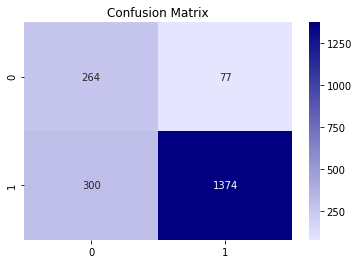

In [30]:
from sklearn.metrics import confusion_matrix
from matplotlib import  pylab as plt
import seaborn as sns

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, cmap=sns.light_palette(
    "navy", as_cmap=True), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()
